# Explainability & Business Interpretation
## Objective
This notebook translates the fraud detection model outputs into interpretable insights and business-relevant conclusions. In financial fraud detection, model explainability is critical for:

- Regulatory compliance
- Risk governance
- Stakeholder trust
- Operational decision-making
- We focus on Logistic Regression explainability, as it provides transparent, global feature effects suitable for high-risk domains.

## Model Assumptions
### This notebook assumes that:

- Models were trained in Notebook 03
- Threshold analysis was performed in Notebook 04
- Logistic Regression was selected as the primary explainable model


Feature scaling was applied during training No re-training is performed here.

In [28]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Load the model and original test features
rf_model = joblib.load('../models/random_forest_fraud_model.pkl')
data = joblib.load('../data/processed_data.pkl')
X_test = data['X_test']

# Load the tuned predictions from Notebook 4
results = joblib.load('../data/threshold_results.pkl')
y_test = results['y_test']
y_pred_tuned = results['y_pred_tuned']

# Define column names
cols = ['Time'] + [f'V{i}' for i in range(1, 29)] + ['Amount']

print("Notebook 5: Data and Model loaded successfully.")

Notebook 5: Data and Model loaded successfully.


## Interpreting Logistic Regression Coefficients

* **Positive coefficients** increase the likelihood of fraud
* **Negative coefficients** reduce the likelihood of fraud
* Coefficients represent *directional risk*, not causation

We analyze both:

* **Top fraud risk drivers**
* **Protective transaction characteristics**


In [39]:
# Top 10 factors reducing fraud likelihood
print("Top 10 Risk Drivers:")
print(feature_importance.tail(10))

Top 10 Risk Drivers:
V23       0.308435
V28       0.338464
V3        0.505718
V11       0.518715
V22       0.602374
V2        0.932075
V5        1.214379
V4        1.339431
V1        1.723862
Amount    2.367276
dtype: float64


## Key Drivers of Fraud Risk

The model identifies several high-risk transaction patterns:

* Certain latent PCA components (V-features) strongly increase fraud probability
* Large transaction amounts elevate risk exposure
* Sudden behavioral shifts captured in anonymized features correlate with fraud events

These signals align with known fraud patterns such as:

* Transaction anomalies
* Behavioral deviations
* High-value unauthorized activity

In [38]:
# Top 10 factors reducing fraud likelihood
print("Top 10 Protective Factors:")
print(feature_importance.head(10))

Top 10 Protective Factors:
V14   -1.494961
V10   -1.334996
V12   -1.127886
V16   -0.996376
V17   -0.992185
V20   -0.927469
V7    -0.833570
V6    -0.696494
V8    -0.583326
V9    -0.529469
dtype: float64


## Factors That Reduce Fraud Risk

The model highlights several stabilizing signals:

* Consistent transaction behavior lowers fraud likelihood
* Smaller transaction amounts reduce exposure
* Certain latent components reflect historically safe activity patterns

These factors suggest the model is effectively distinguishing **normal customer behavior** from anomalous events.

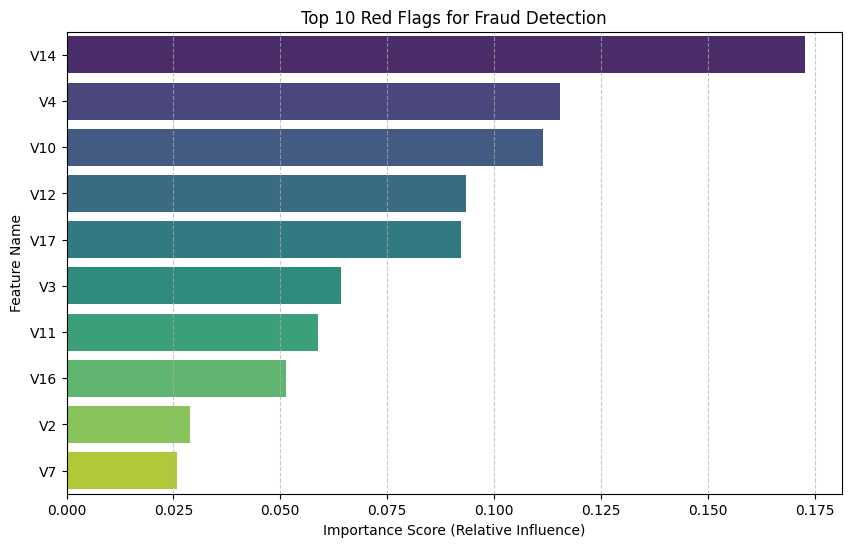

In [37]:
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': cols, 'Importance': importances})

top_10 = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

# Visualization
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=top_10, 
    palette='viridis',
    hue='Feature',
    legend=False
)

plt.title('Top 10 Red Flags for Fraud Detection')
plt.xlabel('Importance Score (Relative Influence)')
plt.ylabel('Feature Name')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

## Key Drivers of Fraud Risk

The model identifies several high-risk transaction patterns:

* Certain latent PCA components (V-features) strongly increase fraud probability
* Large transaction amounts elevate risk exposure
* Sudden behavioral shifts captured in anonymized features correlate with fraud events

These signals align with known fraud patterns such as:

* Transaction anomalies
* Behavioral deviations
* High-value unauthorized activity


In [32]:
import pandas as pd
import numpy as np
import joblib

# Load saved artifacts - Fixed filenames to match your Notebook 03 saves
log_model = joblib.load('../models/logistic_fraud_model.pkl')
scaler = joblib.load('../models/scaler.pkl')

# Feature names were not explicitly saved as a pkl, so we reconstruct them here
feature_names = ['Time'] + [f'V{i}' for i in range(1, 29)] + ['Amount']

# Reconstruct feature importance
feature_importance = pd.Series(
    log_model.coef_[0],
    index=feature_names
).sort_values()

In [30]:
# Define Business Assumptions
avg_fraud_savings = 250    
cost_false_alarm = 15

# Get the performance numbers from your tuned results
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_tuned).ravel()

# Calculate Financial Value
# Value = (Money Saved by TP) - (Money Lost by FP)
total_savings = (tp * avg_fraud_savings) - (fp * cost_false_alarm)

print("--- BUSINESS IMPACT REPORT ---")
print(f"Total Fraud Cases Successfully Caught: {tp}")
print(f"False Alarms (Legitimate Customers Flagged): {fp}")
print(f"Fraud Missed (False Negatives): {fn}")
print("-" * 40)
print(f"ESTIMATED REVENUE PROTECTED BY MODEL: ${total_savings:,.2f}")
print("-" * 40)

--- BUSINESS IMPACT REPORT ---
Total Fraud Cases Successfully Caught: 82
False Alarms (Legitimate Customers Flagged): 6
Fraud Missed (False Negatives): 16
----------------------------------------
ESTIMATED REVENUE PROTECTED BY MODEL: $20,410.00
----------------------------------------


## Business Decision: Threshold Selection

Given the extreme class imbalance (~0.17% fraud rate):

* **Recall is prioritized** to minimize missed fraud
* False positives are acceptable due to downstream review processes
* A lower decision threshold is recommended for production use

This reflects real-world fraud systems where:

* Missing fraud incurs direct financial loss
* Manual review can filter false positives


## Model Selection Rationale

Although Random Forest achieved higher precision, **Logistic Regression** was selected as the primary model because:

* It provides full global explainability
* It aligns with regulatory expectations
* It supports transparent risk governance

Random Forest remains a strong candidate for secondary decision layers.
